# Mapping the Latent Space of Thorax Geometry
## Zebrastack V0 VAE trained on the CovidNet chest radiograph dataset
The zebrastack is a variational auto-encoder that is _very_ roughly aligned with the distributed hierarchical architecture + shifter circuit.  Here it is applied to recognition of the CovidNet chest radiograph dataset.

First, declare some helper pyplot functions to show us thumbnails.

In [1]:
import matplotlib.pyplot as plt
def show_grayscale(rows, columns, at, pixel_array, sz):
    import scipy
    ax = plt.subplot(rows, columns, at)
    interp_array = scipy.ndimage.zoom(pixel_array.reshape(sz,sz), 4.0, order=5)
    plt.imshow(interp_array.reshape(sz*4, sz*4), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def show_original_decoded(original, decoded, sz):
    n = 10  # how many figures we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        show_grayscale(2, n, i+1, original[i], sz)
        show_grayscale(2, n, i+1+n, decoded[i], sz)
    plt.show(block=True)

## Preparing the CovidNet dataset
Now import the CovidNet data and pre-process by:
* converting to grayscale (some CovidNet images are RGB)
* apply a small-window CLAHE
* resize to standard size
* whiten

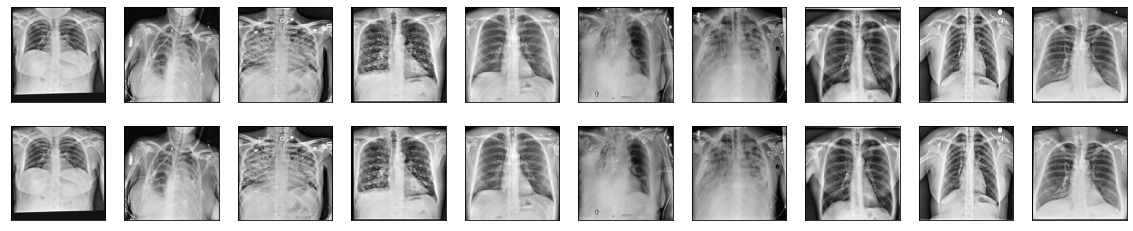

In [2]:
import glob
pngs = glob.glob("e:/github/lin*/COVID*/data/train/*.png")

import cv2
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

import imageio
import numpy as np
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
sz = 128
imgs = []
for png in pngs[:]:
    if len(imgs) % 100 == 0:
        print('{0} of {1}'.format(len(imgs), len(pngs)), end = '\r')
    img = imageio.imread(png)
    if len(img.shape) > 2:
        img = rgb2gray(img)
        img = img_as_ubyte(img)
    img = clahe.apply(img)
    img = resize(img, (sz,sz))
    width = np.max(img) - np.min(img)
    img = img - np.min(img)
    img = img/width
    img = img.reshape((sz,sz,1))
    imgs = imgs + [img]
    
show_original_decoded(imgs[:10], imgs[:10], sz)

Partition the data in to train and test: 90% train and 10% test.  We are assuming all images are from distinct patients, so there is no need to partition by subject.

In [3]:
test_count = int(len(imgs)/10)
x_test = imgs[:test_count]
x_train = imgs[test_count:]
x_train, x_test = np.array(x_train), np.array(x_test)
print(x_train.shape, x_test.shape)

(12072, 128, 128, 1) (1341, 128, 128, 1)


## Defining the Variational Autoencoder
To defined the variational autoencoder, we need to helper functions:
* A function for reparameterized sampling
* A function for KLDiv loss

In [4]:
def sampling(args):
    """
    Reparameterization trick by sampling fr an isotropic unit Gaussian.
    instead of sampling from Q(z|X), sample eps = N(0,I) 
        then z = z_mean + sqrt(var)*eps    
    # Arguments
        args (tensor tuple): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """    
    z_mean, z_log_var = args
    
    from keras import backend as K
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
use_mse = False
def vae_loss(z_mean, z_log_var, y_true, y_pred):
    """
    Compute VAE loss, using either mse or crossentropy.
    # Arguments
        z_mean: mean of Q(z|X)
        z_log_var: log variance of Q(z|X)
        y_true, y_pred: truth and predicated values
    # Returns
        loss value
    """
    from tensorflow.keras.losses import mse, binary_crossentropy
    from keras import backend as K
    img_pixels = sz * sz
    if use_mse:
        match_loss = mse(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    else:
        match_loss = binary_crossentropy(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(match_loss + kl_loss)

We create the Keras model in three parts: 
* encode_only: the recognition subsystem(encoder)
* decode_only: decoder
* autoencoder: the full system

Parameters that control the model are:
* sz: size x size of inputs
* latent_dim: latent dimension at the pulvinar

The layers are named to suggest correspondence between each layer and an area in the distributed hierarchy model / shifter circuit.

In [6]:
from keras.layers import Dense, Input, SpatialDropout2D
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import LocallyConnected2D, ZeroPadding2D
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import ActivityRegularization
from keras import backend as K

latent_dim = 6
plot_model = False

# create encoder side
retina = Input(shape=(sz,sz,1), name='retina_{}'.format(sz))

v1_conv2d = Conv2D(16, (5,5), name='v1_conv2d', activation='relu', padding='same')(retina)
v1_maxpool = MaxPooling2D((2,2), name='v1_maxpool', padding='same')(v1_conv2d)
v1_dropout = SpatialDropout2D(0.1, name='v1_dropout')(v1_maxpool)

v2_conv2d = Conv2D(16, (3,3), name='v2_conv2d', activation='relu', padding='same')(v1_dropout)
v2_maxpool = MaxPooling2D((2,2), name='v2_maxpool', padding='same')(v2_conv2d)

v4_conv2d = Conv2D(32, (3,3), name='v4_conv2d', activation='relu', padding='same')(v2_maxpool)
v4_maxpool = MaxPooling2D((2,2), name='v4_maxpool', padding='same')(v4_conv2d)

pit_conv2d = Conv2D(32, (3,3), name='pit_conv2d', activation='relu', padding='same')(v4_maxpool)
pit_maxpool = MaxPooling2D((2,2), name='pit_maxpool', padding='same')(pit_conv2d)

cit_conv2d = Conv2D(64, (3,3), name='cit_conv2d', activation='relu', padding='same')(pit_maxpool)
cit_maxpool = MaxPooling2D((2,2), name='cit_maxpool', padding='same')(cit_conv2d)

ait_local = LocallyConnected2D(4, (3,3), name='ait_local')(cit_maxpool)
ait_padding = ZeroPadding2D(padding=(1,1), name='ait_padding')(ait_local)
# x = MaxPooling2D((2,2), padding='same', name='ait_maxpool')(ait_padding)

ait_regular = ActivityRegularization(l1=0.0e-4, l2=0.0e-4, name='ait_regular')(ait_padding)

# shape info needed to build decoder model
shape = K.int_shape(ait_regular)
# print(shape)

# generate latent vector Q(z|X)
pulvinar_flatten = Flatten(name='pulvinar_flatten')(ait_regular)
pulvinar_dense = Dense(latent_dim, activation='relu', name='pulvinar_dense')(pulvinar_flatten)
z_mean = Dense(latent_dim, name='z_mean')(pulvinar_dense)
z_log_var = Dense(latent_dim, name='z_log_var')(pulvinar_dense)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

from keras.models import Model
encoder = Model(retina, [z_mean, z_log_var, z], name='v1_to_pulvinar_encoder')
encoder.summary()
    
from keras.utils import plot_model
if plot_model: 
    plot_model(encoder, to_file='data\{}.png'.format(encoder.name), show_shapes=True)

Using TensorFlow backend.


Model: "v1_to_pulvinar_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
retina_128 (InputLayer)         (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
v1_conv2d (Conv2D)              (None, 128, 128, 16) 416         retina_128[0][0]                 
__________________________________________________________________________________________________
v1_maxpool (MaxPooling2D)       (None, 64, 64, 16)   0           v1_conv2d[0][0]                  
__________________________________________________________________________________________________
v1_dropout (SpatialDropout2D)   (None, 64, 64, 16)   0           v1_maxpool[0][0]                 
_____________________________________________________________________________

The decoder is defined as the reverse layers of the encoder.

In [7]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
pulvinar_dense_back = Dense(shape[1] * shape[2] * shape[3], name='pulvinar_dense_back', 
                            activation='relu')(latent_inputs)
pulvinar_antiflatten = Reshape((shape[1], shape[2], shape[3]), name='pulvinar_antiflatten')(pulvinar_dense_back)

ait_local_back = LocallyConnected2D(4, (3,3), name='ait_local_back')(pulvinar_antiflatten)
ait_padding_back = ZeroPadding2D(padding=(1,1), name='ait_padding_back')(ait_local_back)
ait_upsample_back = UpSampling2D((2,2), name='ait_upsample_back')(ait_padding_back)

cit_conv2d_trans = Conv2DTranspose(64, (3,3), name='cit_conv2d_trans', 
                                   activation='relu', padding='same')(ait_upsample_back)
cit_upsample_back = UpSampling2D((2,2), name='cit_upsample_back')(cit_conv2d_trans)

pit_conv2d_trans = Conv2DTranspose(32, (3,3), name='pit_conv2d_trans', 
                                   activation='relu', padding='same')(cit_upsample_back)
pit_upsample_back = UpSampling2D((2,2), name='pit_upsample_back')(pit_conv2d_trans)

v4_conv2d_trans = Conv2DTranspose(32, (3,3), name='v4_conv2d_trans', 
                                  activation='relu', padding='same')(pit_upsample_back)
v4_upsample_back = UpSampling2D((2,2), name='v4_upsample_back')(v4_conv2d_trans)

v2_conv2d_trans = Conv2DTranspose(16, (3,3), name='v2_conv2d_trans', 
                                  activation='relu', padding='same')(v4_upsample_back)
v2_upsample_back = UpSampling2D((2,2), name='v2_upsample_back')(v2_conv2d_trans)

v1_conv2d_5x5_back = Conv2D(1, (5,5), name='v1_conv2d_5x5_back', 
                            activation='sigmoid', padding='same')(v2_upsample_back)
decoder = Model(latent_inputs, v1_conv2d_5x5_back, name='pulvinar_to_v1_decoder')
decoder.summary()
if plot_model: 
    plot_model(decoder, to_file='data\{}.png'.format(decoder.name), show_shapes=True)

Model: "pulvinar_to_v1_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 6)                 0         
_________________________________________________________________
pulvinar_dense_back (Dense)  (None, 64)                448       
_________________________________________________________________
pulvinar_antiflatten (Reshap (None, 4, 4, 4)           0         
_________________________________________________________________
ait_local_back (LocallyConne (None, 2, 2, 4)           592       
_________________________________________________________________
ait_padding_back (ZeroPaddin (None, 4, 4, 4)           0         
_________________________________________________________________
ait_upsample_back (UpSamplin (None, 8, 8, 4)           0         
_________________________________________________________________
cit_conv2d_trans (Conv2DTran (None, 8, 8, 64

Finally put it together to the full model, and compile with the desired optimizer

In [8]:
autoencoder_output = decoder(encoder(retina)[2])
autoencoder = Model(retina, autoencoder_output, name='v1_to_pulvinar_vae')

# now compile with the optimizer VAE loss function
optimizer = 'adadelta'
autoencoder.compile(optimizer=optimizer, 
                    loss=lambda y_true, y_pred: vae_loss(z_mean, z_log_var, y_true, y_pred))
autoencoder.summary()
if plot_model: 
    plot_model(autoencoder, to_file='data\{}.png'.format(autoencoder.name), show_shapes=True)

Model: "v1_to_pulvinar_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
retina_128 (InputLayer)      (None, 128, 128, 1)       0         
_________________________________________________________________
v1_to_pulvinar_encoder (Mode [(None, 6), (None, 6), (N 44826     
_________________________________________________________________
pulvinar_to_v1_decoder (Mode (None, 128, 128, 1)       36145     
Total params: 80,971
Trainable params: 80,971
Non-trainable params: 0
_________________________________________________________________


## Training the model
Train by calling .fit with the training data.  
* Batch size of 512 helps convergence, but causes resource exhaustion > 128x128.
* Epochs > 1024 take a while, but tend to lead to better results

In [15]:
autoencoder.fit(x_train, x_train, 
                epochs=256, batch_size=512, 
                shuffle=True, validation_data=(x_test, x_test))

Train on 12072 samples, validate on 1341 samples
Epoch 1/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9509.8295 - val_loss: 9544.9387
Epoch 2/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9503.5867 - val_loss: 9530.4215
Epoch 3/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9503.9423 - val_loss: 9570.7591
Epoch 4/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9506.1569 - val_loss: 9529.7540
Epoch 5/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9506.2356 - val_loss: 9560.3986
Epoch 6/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9498.9497 - val_loss: 9600.2062
Epoch 7/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9500.4929 - val_loss: 9566.3454
Epoch 8/256
12072/12072 [==============================] - 13s 1ms/step - loss: 9500.5837 - val_loss: 9576.7780
Epoch 9/256
12072/12072 [==============================

12072/12072 [==============================] - 14s 1ms/step - loss: 9492.7528 - val_loss: 9528.2767
Epoch 74/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9483.1487 - val_loss: 9554.6883
Epoch 75/256
12072/12072 [==============================] - 15s 1ms/step - loss: 9494.8845 - val_loss: 9562.2053
Epoch 76/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9485.9478 - val_loss: 9559.6069
Epoch 77/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9492.6781 - val_loss: 9534.3418
Epoch 78/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9482.7507 - val_loss: 9548.4948
Epoch 79/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9497.6797 - val_loss: 9526.3216
Epoch 80/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9487.0566 - val_loss: 9550.2517
Epoch 81/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9493.0383 - val_loss: 9527.7

12072/12072 [==============================] - 14s 1ms/step - loss: 9479.3264 - val_loss: 9553.1937
Epoch 146/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9484.3093 - val_loss: 9560.9283
Epoch 147/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9486.5277 - val_loss: 9568.0649
Epoch 148/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9483.0304 - val_loss: 9520.4238
Epoch 149/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9482.9846 - val_loss: 9550.6356
Epoch 150/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9483.2797 - val_loss: 9521.8099
Epoch 151/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9482.1444 - val_loss: 9525.1737
Epoch 152/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9479.3317 - val_loss: 9533.1356
Epoch 153/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9484.9988 - val_loss

Epoch 217/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9479.6079 - val_loss: 9599.8584
Epoch 218/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9472.0856 - val_loss: 9527.6334
Epoch 219/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9477.0330 - val_loss: 9562.3058
Epoch 220/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9473.2945 - val_loss: 9552.5706
Epoch 221/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9476.9673 - val_loss: 9603.6026
Epoch 222/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9474.6444 - val_loss: 9554.6654
Epoch 223/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9474.0603 - val_loss: 9552.6210
Epoch 224/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9473.9051 - val_loss: 9560.9951
Epoch 225/256
12072/12072 [==============================] - 14s 1ms/step - loss: 9477.6

## Inspecting Reconstructing Images
To qualitatively assess the model, look at a few images and their reconstructions from latent vectors

In [10]:
from functools import lru_cache

@lru_cache(maxsize=None)
def decode_latent(decoder, latent_vector:tuple):
    """
    helper to decode latent, with caching to speed up
    # Arguments
        decode_only: model for decoding
        latent_vector: _tuple_ representing the vector to be decoded
    # Returns
        decoded image
    """
    latent_vector_arr = np.array([latent_vector])
    return decoder.predict(latent_vector_arr)

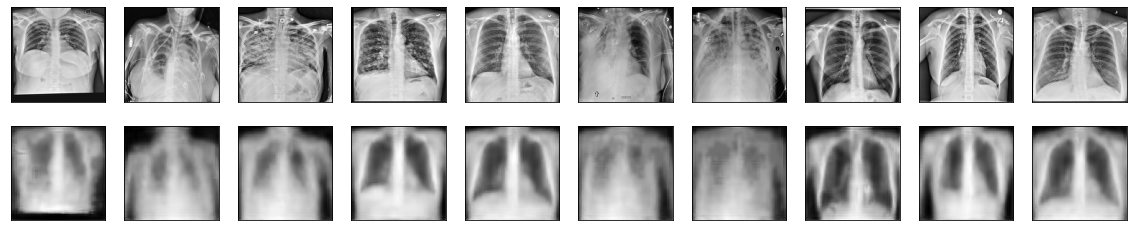

In [17]:
encode_only_imgs = encoder.predict(x_test[:10])
show_histo = False
if show_histo:
    for n in range(10):
        print("shape of encoded = ", encode_only_imgs[2].shape)
        hist, bins = np.histogram(encode_only_imgs[2])
        print(hist)
        print(bins)
decoded_imgs = \
    [decode_latent(decoder, tuple(latent_vector)) 
         for latent_vector in encode_only_imgs[2]]
show_original_decoded(x_test[:10], decoded_imgs, sz)

## Saving the Model
If the model output looks good, then save it for subsequent use

In [18]:
encoder.save('data\zebrastack_v0_covidnet_encoder_model')
decoder.save('data\zebrastack_v0_covidnet_decoder_model')

## Anat0Mixer Interaction

In [21]:
def update_image_for_sliders(**kwargs):
    from scipy.ndimage import zoom
    # print(tuple(kwargs.values()))
    decoded_pixel_array = decode_latent(decoder, tuple(kwargs.values()))
    interp_array = zoom(decoded_pixel_array.reshape(sz,sz), 4.0, order=5)
    interp_array = interp_array.reshape(sz*4, sz*4)
    plt.imshow(interp_array, cmap='gray')
    return kwargs['1']

In [22]:
%matplotlib inline
from ipywidgets import FloatSlider, interactive_output, Layout, HBox, VBox

kwargs = {}
for k in range(latent_dim):
    kwargs[str(k)] = \
        FloatSlider(value = 0,
                    min = -2.0, max = 2.0, 
                    step = 0.01,
                    orientation='vertical',
                    layout=Layout(padding='0%'))

slider_widgets = interactive_output(update_image_for_sliders, kwargs)
slider_widgets.layout.height = '350px'
display(HBox(list(kwargs.values()), layout = Layout(padding='0%')))
display(slider_widgets)

Output(layout=Layout(height='350px'))